<a href="https://colab.research.google.com/github/maniceet/stars-from-reviews/blob/master/Stars_from_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
!pip install scikit-plot

In [0]:
#Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import gc
import nltk
import pickle
import copy
from textblob import TextBlob
import re, string, unicodedata
from bs4 import BeautifulSoup
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
from joblib import Parallel, delayed
import multiprocessing
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
nlp = spacy.load('en')
%matplotlib inline
np.random.seed(17)

In [0]:
#Function to evaluate model performance
def evaluate_model_preds(y_true, y_pred):
    
    # F1-Score
    f1 = f1_score(y_true, y_pred, pos_label=1, average='macro')
    print("F1: ", f1)
    print('-'*100)   
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy: ", accuracy)
    print('-'*100)
    # Confusion Matrix
    plt.figure(figsize=(10,10))
    skplt.metrics.plot_confusion_matrix(y_true=y_true, y_pred=y_pred)
    plt.show()

    #Classification Report
    print('-'*100)
    print(classification_report(y_true, y_pred))

In [0]:
data = pd.read_excel('/content/drive/My Drive/Temp/Merilytics DS test.xlsx')
print(data.shape)
data.head(3)

(668590, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1,6,1,0,Total bill for this horrible service? Over $8G...,2013-07-05 04:34:00
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,14/01/2017 21:30
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5,3,0,0,I have to say that this office really has it t...,2016-09-11 20:09:00


## EDA

In [0]:
#Looking at stars distribution 
data.stars.value_counts()/data.shape[0]

5    0.440642
4    0.218496
1    0.150559
3    0.109587
2    0.080716
Name: stars, dtype: float64

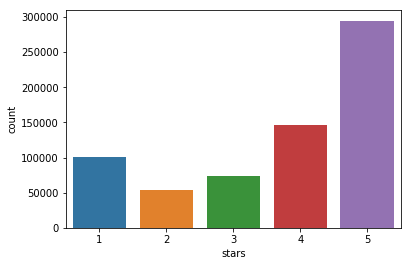

In [0]:
sns.countplot(x='stars', data = data)

In [0]:
data['len_text'] = data['text'].astype(str).apply(lambda x: len(x.split(' ')))

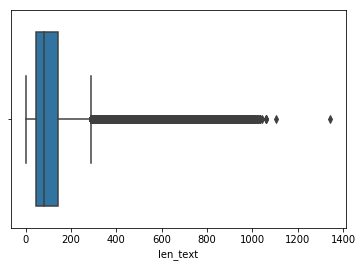

In [0]:
ax = sns.boxplot(data['len_text'])

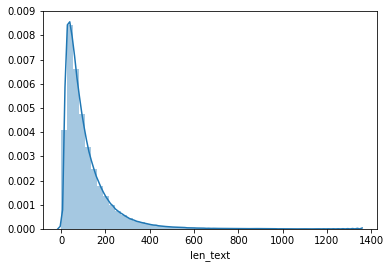

In [0]:
sns.distplot(data['len_text']);

In [0]:
data['len_text'].describe()

count    668590.000000
mean        111.599303
std         105.079078
min           1.000000
25%          44.000000
50%          79.000000
75%         142.000000
max        1343.000000
Name: len_text, dtype: float64

In [0]:
print(data[data.len_text > 200].shape)
data[data.len_text > 200].iloc[0]['text']


(91999, 10)


"I *adore* Travis at the Hard Rock's new Kelly Cardenas Salon!  I'm always a fan of a great blowout and no stranger to the chains that offer this service; however, Travis has taken the flawless blowout to a whole new level!  \n\nTravis's greets you with his perfectly green swoosh in his otherwise perfectly styled black hair and a Vegas-worthy rockstar outfit.  Next comes the most relaxing and incredible shampoo -- where you get a full head message that could cure even the very worst migraine in minutes --- and the scented shampoo room.  Travis has freakishly strong fingers (in a good way) and use the perfect amount of pressure.  That was superb!  Then starts the glorious blowout... where not one, not two, but THREE people were involved in doing the best round-brush action my hair has ever seen.  The team of stylists clearly gets along extremely well, as it's evident from the way they talk to and help one another that it's really genuine and not some corporate requirement.  It was so mu

In [0]:
data[data.len_text > 1300].iloc[0]['text']

'Solid 4.5 since giving a 5 is for above and beyond.                                                                    \n                                                                              \nPros:                                                                      \n                                                                             \n- Absolutely great fish entree options!!!           \n                                                                              \n- Prices reflect good portions sizes.                                    \n                                                                               \n- Friday burrito deal...came with Monster drink!!!                                                                     \n                                                                              \nCons:\n\n- I ordered no beans, but they promptly fixed after I discovered it from my first bite.  Would have been nice if they comp the meal, but no bi

In [0]:
print(data.useful.describe())
print(np.quantile(data.useful, 0.975))

count    668590.000000
mean          1.348044
std           3.208699
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         303.000000
Name: useful, dtype: float64
8.0


In [0]:
#It seems useful goes from 0-10 and the rest are invalid numbers
data['useful'] = np.where(data['useful'] > 10, 10, data['useful'])

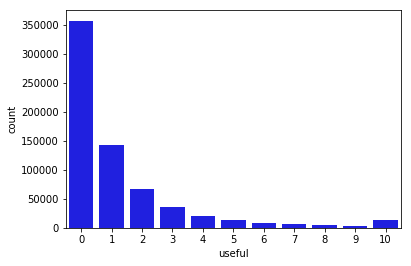

In [0]:
sns.countplot(x='useful',data = data, color = 'blue')

In [0]:
print(data.funny.describe())
print(np.quantile(data.funny, 0.95))

count    668590.000000
mean          0.467548
std           1.831260
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         190.000000
Name: funny, dtype: float64
2.0


In [0]:
#It seems funny is a binary flag and the rest are wrong entries
data['funny'] = np.where(data['funny'] > 0, 1,0)

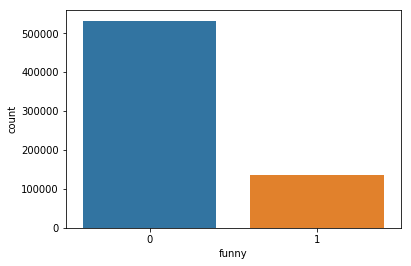

In [0]:
sns.countplot(x='funny',data = data)

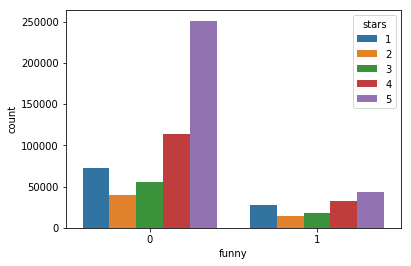

In [0]:
sns.countplot(x='funny',hue = 'stars', data = data)

In [0]:
data.isna().sum()

review_id      8305
user_id        8325
business_id    8715
stars             0
useful            0
funny             0
cool              0
text             29
date              0
len_text          0
dtype: int64

In [0]:
#Removing na rows as they are not a significant chunk of our population
data.dropna(subset = ['text'], inplace = True)

In [0]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['text'], 20)

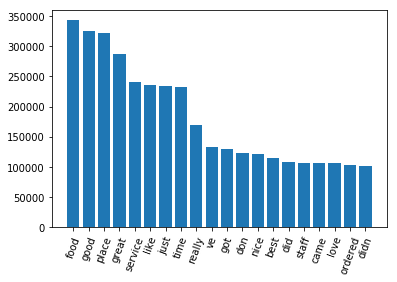

In [0]:
plt.bar(range(len(common_words)), [val[1] for val in common_words], align='center')
plt.xticks(range(len(common_words)), [val[0] for val in common_words])
plt.xticks(rotation=70)
plt.show()

## Data Cleaning

In [0]:
#Reading a few reviews with stars
print(data['text'][0], data['stars'][0])
print('------------------')
print(data['text'][345], data['stars'][345])
print('------------------')
print(data['text'][3235], data['stars'][3235])

Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs. 1
------------------
The food was very good . The waitress was very inventive . The only thing is my I felt so sick after eating it . I'm not sure if it's just my stomach not being able to handle it or what but I felt terrible . The staff at the front was very friendly and talkative 4
------------------
******************* 1955 ******************* 

If you are craving for Southern food, here is where you need to come. I'm not a fan of greasy food unless I'm hangover. So what's better to do than having brunch here after a long night of clubbing and strip club. You hear me right!

Yardbird, a traditional Southern eatery for themed decor, chicken & waffles, grits & more, plus craft cocktails.

- Waffle and Crispy Chicken, pepper jelly

- Lewellyn's Fine Fried Chicken, 1/2 of our famous b

In [0]:
from contraction import expand_contractions
expand = lambda x: expand_contractions(x)

In [0]:
data['text'] = data['text'].apply(expand)

In [0]:
#Removing special characters and whitespaces
def clean_text(text):
    if not pd.isna(text):
      # Remove HTML tags
      text = BeautifulSoup(text, 'html.parser').get_text()
      text = text.lower()
      text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
      text = re.sub(r"\r\n", " ", text)
      # Match alphanumerics with whitespaces
      text = re.sub(r'[^\w\s]','',text, re.UNICODE)
      text = re.sub('[^A-Za-z0-9]+', ' ', text)
      return text
    else:
      return np.nan

In [0]:
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(x))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [0]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word, pos = 'v') for word in text.split()])
    text = ' '.join([lemmatizer.lemmatize(word, pos = 'a') for word in text.split()])
    return text

lemma = lambda x: lemmatize_text(x)

In [0]:
data['cleaned_ml'] = data['cleaned_text'].apply(lemma)

In [0]:
#Reading a few reviews with stars
print(data['cleaned_text'][0], data['stars'][0])
print('------------------')
print(data['cleaned_text'][345], data['stars'][345])
print('------------------')
print(data['cleaned_text'][3235], data['stars'][3235])

total bill for this horrible service over 8gs these crooks actually had the nerve to charge us 69 for 3 pills i checked online the pills can be had for 19 cents each avoid hospital ers at all costs 1
------------------
the food was very good the waitress was very inventive the only thing is my i felt so sick after eating it i am not sure if it is just my stomach not being able to handle it or what but i felt terrible the staff at the front was very friendly and talkative 4
------------------
 1955 if you are craving for southern food here is where you need to come i am not a fan of greasy food unless i am hangover so what is better to do than having brunch here after a long night of clubbing and strip club you hear me right yardbird a traditional southern eatery for themed decor chicken waffles grits more plus craft cocktails waffle and crispy chicken pepper jelly lewellyns fine fried chicken 1 2 of our famous bird served with honey hot sauce their infamous chicken dish fried green tom

In [0]:
#Saving cleaned data for further use
#data.to_csv('/content/drive/My Drive/Temp/data_cleaned.csv', index = False)

In [0]:
#Loading the data
data = pd.read_csv('/content/drive/My Drive/Temp/data_cleaned.csv')

In [0]:
data.dropna(subset = ['cleaned_text'], inplace = True)

In [0]:
#Splitting the data into train and test
train, test = train_test_split(data, train_size = 0.8, stratify = data['stars'], random_state = 17)

In [10]:
print(train.shape)
print(test.shape)

(534840, 12)
(133710, 12)


## Undersampling Train Data
Due to class imbalance, for training we will undersample the classes to the minority class and then check performance on test set

In [11]:
train['stars'].value_counts()

5    235678
4    116860
1     80523
3     58611
2     43168
Name: stars, dtype: int64

In [12]:
train['stars'].value_counts()/train.shape[0]

5    0.440651
4    0.218495
1    0.150555
3    0.109586
2    0.080712
Name: stars, dtype: float64

In [13]:
#Upsampling class 2
df_majority = train[train.stars != 2]
df_minority = train[train.stars == 2]

df_minority_upsampled = resample(df_minority, replace = True, 
                                 n_samples = 80523,
                                 random_state = 17
                                )

train = pd.concat([df_majority, df_minority_upsampled])
print(train.shape)
print(train['stars'].value_counts())

(572195, 12)
5    235678
4    116860
2     80523
1     80523
3     58611
Name: stars, dtype: int64


In [14]:
#Upsampling Class 3
df_majority = train[train.stars != 3]
df_minority = train[train.stars == 3]

df_minority_upsampled = resample(df_minority, replace = True, 
                                 n_samples = 80523,
                                 random_state = 17
                                )

train = pd.concat([df_majority, df_minority_upsampled])
print(train.shape)
print(train['stars'].value_counts())

(594107, 12)
5    235678
4    116860
3     80523
2     80523
1     80523
Name: stars, dtype: int64


In [0]:
X_ml = train['cleaned_ml'].values.reshape(-1, 1)
X_dl = train['cleaned_text'].values.reshape(-1, 1)
y = train['stars']

In [16]:
#Downsampling to lowest class distribution
rus = RandomUnderSampler(random_state = 17)
X_ml_resampled, y_ml_resampled = rus.fit_resample(X_ml, y)
print(sorted(Counter(y_ml_resampled).items()))

[(1, 80523), (2, 80523), (3, 80523), (4, 80523), (5, 80523)]


In [17]:
rus = RandomUnderSampler(random_state = 17)
X_dl_resampled, y_dl_resampled = rus.fit_resample(X_dl, y)
print(sorted(Counter(y_ml_resampled).items()))

[(1, 80523), (2, 80523), (3, 80523), (4, 80523), (5, 80523)]


## Classical NLP Model

In [0]:
vectorizer_word = TfidfVectorizer(analyzer='word', stop_words = 'english', ngram_range = (1, 3), max_features = 400000)
vectorizer_word = vectorizer_word.fit(X_ml_resampled.ravel())

In [0]:
#Saving the vectorizer for use during evaluating the model on test set
with open('/content/drive/My Drive/Temp/Models/reviews/vectorizer.pkl', 'wb') as f:
  pickle.dump(vectorizer_word, f)

In [0]:
#Loading the tf-idf vectorizer
with open('/content/drive/My Drive/Temp/Models/reviews/vectorizer.pkl', 'rb') as f:
  vectorizer_word = pickle.load(f)

In [0]:
X = vectorizer_word.transform(X_ml_resampled.ravel())

In [23]:
y = y_ml_resampled
print(X.shape)

(402615, 400000)


In [0]:
baseline_cv_word = GridSearchCV(MultinomialNB(), {'alpha': np.arange(0.01, 1, 0.05)}, 
                           cv=5, scoring = 'accuracy', n_jobs = -1)

In [25]:
baseline_cv_word.fit(X,y)
print(baseline_cv_word.best_params_)
print(f"Baseline score is {baseline_cv_word.best_score_}")

{'alpha': 0.01}
Baseline score is 0.6662791997317536


In [26]:
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = 0.9, 
                                                  random_state = 17, stratify = y)
print(X_train.shape)
print(X_val.shape)

(362353, 400000)
(40262, 400000)


In [0]:
nb_clf_word = MultinomialNB(alpha= 0.01).fit(X_train, y_train)

In [0]:
with open('/content/drive/My Drive/Temp/Models/reviews/nb_word.model', 'wb') as f:
  pickle.dump(nb_clf_word, f)

F1:  0.6741848495236198
----------------------------------------------------------------------------------------------------
Accuracy:  0.6731409269286176
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

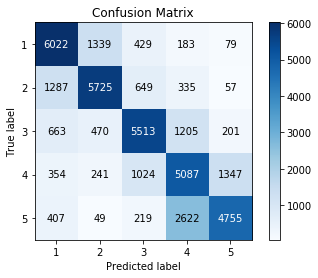

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.69      0.75      0.72      8052
           2       0.73      0.71      0.72      8053
           3       0.70      0.68      0.69      8052
           4       0.54      0.63      0.58      8053
           5       0.74      0.59      0.66      8052

    accuracy                           0.67     40262
   macro avg       0.68      0.67      0.67     40262
weighted avg       0.68      0.67      0.67     40262



In [29]:
preds_nb = nb_clf_word.predict(X_val)
evaluate_model_preds(y_val, preds_nb)

**Decent results with naive bayes, Almost similar F1 scores across classes except for class 4.Lets see what logistic regression does**

In [0]:
log_reg = LogisticRegression(dual = False, solver = 'saga', multi_class= 'multinomial', max_iter= 1000)

In [44]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
with open('/content/drive/My Drive/Temp/Models/reviews/log_reg.model', 'wb') as f:
  pickle.dump(log_reg, f)

F1:  0.8431733492994662
----------------------------------------------------------------------------------------------------
Accuracy:  0.8434068436027852
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

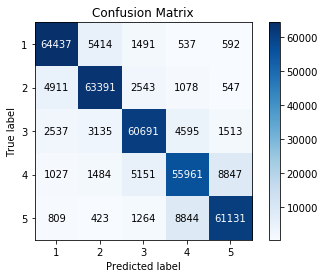

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.87      0.89      0.88     72471
           2       0.86      0.87      0.87     72470
           3       0.85      0.84      0.85     72471
           4       0.79      0.77      0.78     72470
           5       0.84      0.84      0.84     72471

    accuracy                           0.84    362353
   macro avg       0.84      0.84      0.84    362353
weighted avg       0.84      0.84      0.84    362353



In [48]:
#Checking performance on train set
preds_lr = log_reg.predict(X_train)
evaluate_model_preds(y_train, preds_lr)

F1:  0.7086547317493259
----------------------------------------------------------------------------------------------------
Accuracy:  0.709378570364115
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

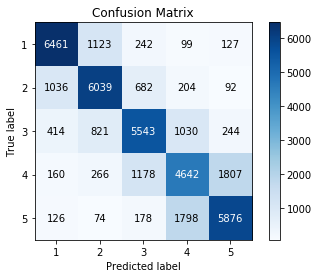

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.79      0.80      0.80      8052
           2       0.73      0.75      0.74      8053
           3       0.71      0.69      0.70      8052
           4       0.60      0.58      0.59      8053
           5       0.72      0.73      0.73      8052

    accuracy                           0.71     40262
   macro avg       0.71      0.71      0.71     40262
weighted avg       0.71      0.71      0.71     40262



In [49]:
#Checking performance on validation
preds_lr = log_reg.predict(X_val)
evaluate_model_preds(y_val, preds_lr)

**Slightly better performance than naive bayes, both classical nlp models struggle with class 4**

## Deep Learning Models

In [0]:
dl_df = pd.DataFrame(X_dl_resampled, columns = ['text'])
dl_df['stars'] = y_dl_resampled

In [0]:
dl_df.shape

(402615, 2)

In [0]:
train_df, valid_df = train_test_split(dl_df, test_size = 0.1, stratify = dl_df['stars'],
                                      random_state = 17)

#### ULM Fit

In [0]:
from functools import reduce
from fastai.text import *
from fastai.callbacks import *
from fastai import *
from fastai.metrics import *

In [0]:
torch.cuda.empty_cache()

In [0]:
bs = 128
# Language model data
data_lm = TextLMDataBunch.from_df(path = os.getcwd(),train_df = train_df, valid_df = valid_df, text_cols= 'text', label_cols= 'stars')

data_lm.save('data_lm.pkl')

In [0]:
data_lm.show_batch(1)

idx,text
0,i said it a little louder and he swung around and said do not you yell at me no one yells at me we were looking for the total amount we needed to pay and he apparently forgot to push that button he was every kind of awful person you would ever want to meet and sarcastic as well hopefully he will not be employed there much longer it is


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03
Min loss divided by 10: 1.45E-02


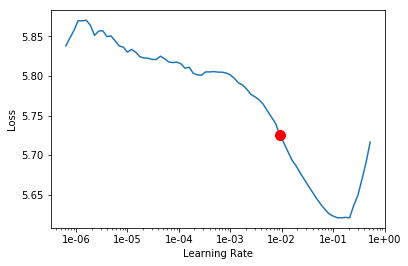

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15, suggestion = True)

epoch,train_loss,valid_loss,accuracy,time
0,4.460498,4.362292,0.231305,2:06:14


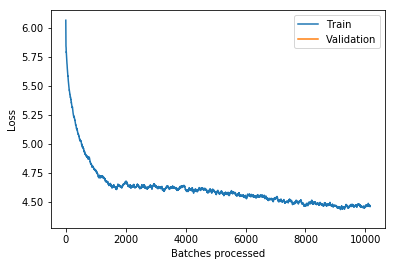

In [0]:
learn.fit_one_cycle(1, max_lr = 1e-2, moms=(0.8,0.7))
learn.recorder.plot_losses()

In [0]:
learn.save('/content/drive/My Drive/Temp/Models/reviews/first_lm')

In [0]:
learn.load('/content/drive/My Drive/Temp/Models/reviews/first_lm');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-2/(2.6**4), 1e-2), moms=(0.8,0.7))
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,4.054261,4.014531,0.272013,2:32:57


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save('/content/drive/My Drive/Temp/Models/reviews/fine_tuned_lm')

In [0]:
learn.save_encoder('/content/drive/My Drive/Temp/Models/reviews/fine_tuned_enc')

In [0]:
data_clas = TextClasDataBunch.from_df(path = os.getcwd(), train_df = train_df, 
          valid_df = valid_df, text_cols= 'text', label_cols= 'stars', 
          classes = [1,2,3,4,5], bs=128)

In [0]:
path = os.getcwd()

In [0]:
data_clas.save('data_clas.pkl')


In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=32)
data_clas.show_batch(2)

text,target
xxbos i had the worst experience of my life using hertz i will not only never ever use them again but when all my friends and family heard what happened to me they will not use you either in fear of what happened i select to be picked up on the website it asks me to give the address of where i would like to be picked up and the,1
xxbos read this dr xxunk was wonderful and kind this is why it is such a shame that the rest of my experience was beyond horrifying i saw the doctor friday march 16 2018 i was told to come back for a follow up to see if my bone was healing i returned today monday april 2 2018 for my follow up appointment i paid my 60 copay and then,1


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('/content/drive/My Drive/Temp/Models/reviews/fine_tuned_enc');
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03
Min loss divided by 10: 1.20E-02


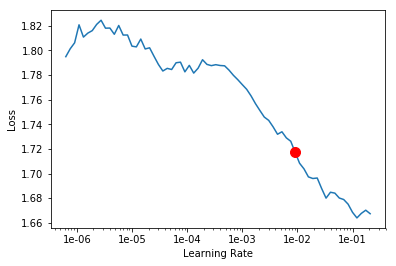

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion= True, skip_end=15)

In [0]:
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,1.298297,1.210647,0.475063,52:41


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save('/content/drive/My Drive/Temp/Models/reviews/first_classifier')

In [0]:
learn.load('/content/drive/My Drive/Temp/Models/reviews/first_classifier');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 6.31E-08


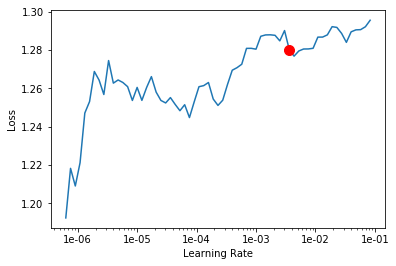

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion= True, skip_end=15)

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.889496,0.820282,0.649670,58:32


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04
Min loss divided by 10: 6.31E-04


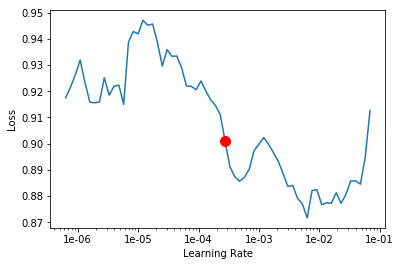

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion= True, skip_end=15)

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, 3e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.818160,0.757455,0.676320,1:44:43


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 6.31E-04


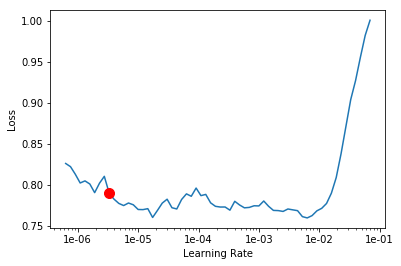

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion= True, skip_end=15)

In [0]:
learn.freeze_to(-4)
learn.fit_one_cycle(1, 3e-6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.754001,0.753345,0.679897,2:10:30


In [0]:
learn.save('/content/drive/My Drive/Temp/Models/reviews/fine_tuned_classifier')

In [0]:
learn.export('/content/drive/My Drive/Temp/Models/reviews/ulmfit_model.pkl')

### Using BERT
Due to the time constraints BERT could not be used. However, BERT would've outperformed both classical NLP methods and ulmfit

## Evaluation on Test Set

In [0]:
#Loading Models

#Naive Bayes Model
with open('/content/drive/My Drive/Temp/Models/reviews/nb_word.model', 'rb') as f:
  nb_model = pickle.load(f)

#Logistic Regression model
with open('/content/drive/My Drive/Temp/Models/reviews/log_reg.model', 'rb') as f:
  log_reg = pickle.load(f)

In [0]:
#Loading ULMfit Model
learn_ulmfit = load_learner('/content/drive/My Drive/Temp/Models/reviews/', 'ulmfit_model.pkl')

In [0]:
#Getting Test data ready
#Loading Vectorizer
with open('/content/drive/My Drive/Temp/Models/reviews/vectorizer.pkl', 'rb') as f:
  vectorizer_word = pickle.load(f)

In [55]:
print(test.shape)
test.head(3)

(133710, 12)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,len_text,cleaned_text,cleaned_ml
39251,IHNZ-DwEbJyjEagz5YQYXg,nfQ6z0aX5ImB5ssWrDIBLw,IbMuq-Hj_S_tEo9joFN3Vg,5,3,0,0,My Mom accidentally sat on her glasses a few d...,26/09/2014 02:02,89,my mom accidentally sat on her glasses a few d...,my mom accidentally sit on her glass a few day...
215288,4Zb1eofRgqdHV7Sm1vUumA,PliiFWekO3t3kLYh3f_yTA,YF4QJ_j-PM7cMZja6K1MwQ,5,10,1,10,This is honestly the only day club worth going...,30/09/2015 02:12,174,this is honestly the only day club worth going...,this be honestly the only day club worth go to...
277096,xilpR7OSQm9bZmDVU1thCw,ENgL9AxV7uu-v5EUCpF69Q,uczILVmOHqosb7XZeDSlOw,4,5,1,5,We wandered over here after dinner at Yardbird...,2018-09-04 19:16:00,257,we wandered over here after dinner at yardbird...,we wander over here after dinner at yardbird e...


In [0]:
ml_test = vectorizer_word.transform(test['cleaned_ml'])
y_ml = test['stars']

F1:  0.5158975857817817
----------------------------------------------------------------------------------------------------
Accuracy:  0.5750654401316282
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

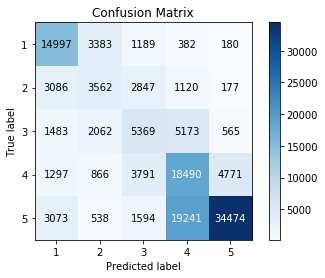

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.63      0.74      0.68     20131
           2       0.34      0.33      0.34     10792
           3       0.36      0.37      0.36     14652
           4       0.42      0.63      0.50     29215
           5       0.86      0.59      0.70     58920

    accuracy                           0.58    133710
   macro avg       0.52      0.53      0.52    133710
weighted avg       0.63      0.58      0.59    133710



In [51]:
#Testing Naive Bayes Model on test Data
pred_nb_test = nb_model.predict(ml_test)
evaluate_model_preds(y_ml, pred_nb_test)

**Not very good scores on test data, where the class imbalance was there, naive bayes doesn't do well on both accuracy and f1 score when compared to its validation results, it also doesn't do that well on classes 2 and 3**

F1:  0.5851704157413693
----------------------------------------------------------------------------------------------------
Accuracy:  0.6484107396604593
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

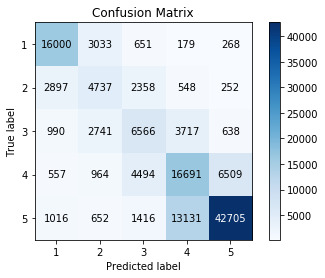

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.75      0.79      0.77     20131
           2       0.39      0.44      0.41     10792
           3       0.42      0.45      0.44     14652
           4       0.49      0.57      0.53     29215
           5       0.85      0.72      0.78     58920

    accuracy                           0.65    133710
   macro avg       0.58      0.60      0.59    133710
weighted avg       0.67      0.65      0.66    133710



In [52]:
#Testing Logistic Regression Model on test Data
pred_lr_test = log_reg.predict(ml_test)
evaluate_model_preds(y_ml, pred_lr_test)

**The logistic regression model does better than the naive bayes but still falls short in comparison to its performance on the validation set, it also doesn't do that well on class 2,3 and 4**

In [0]:
#Preparing data for deep learning testing
dl_test_data = test.filter(items = ['cleaned_text', 'stars'])
dl_test_data.dropna(inplace = True)

F1:  0.6695676372052903
----------------------------------------------------------------------------------------------------
Accuracy:  0.70785
----------------------------------------------------------------------------------------------------


<Figure size 720x720 with 0 Axes>

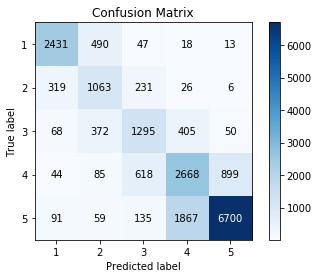

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.82      0.81      0.82      2999
           2       0.51      0.65      0.57      1645
           3       0.56      0.59      0.57      2190
           4       0.54      0.62      0.57      4314
           5       0.87      0.76      0.81      8852

    accuracy                           0.71     20000
   macro avg       0.66      0.68      0.67     20000
weighted avg       0.73      0.71      0.72     20000



In [56]:
#Testing on ULMFit
#Testing for only 20000 samples as prediction with ulmfit takes some time
preds_ulmfit  = [int(str(learn_ulmfit.predict(i)[0])) for i in dl_test_data['cleaned_text'][:20000] ]
evaluate_model_preds(dl_test_data['stars'][:20000], preds_ulmfit)

**The deep learning method gives excellent results, close to the validation set results on the test sample, outperforming logistic regression and naive bayes by a long margin, if time were there we could have ensembled BERT and ULMfit to gain even more performance, however, ULMfit will be the model i'll chose for the classification task here**